In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import stats

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape
from tensorflow.keras import losses, utils, Model

In [5]:
# concatenate data from different units (data in spike_data.mat are already sorted)
def concat(*data_block):
  feature_num = data_block[0].shape[1]
  f = lambda x: x.shape[0]
  total_row_num = sum(f(e) for e in data_block)
  # create an empty array and copy data into it
  data_concat = np.empty((total_row_num, feature_num), dtype='float32')
  ctr = 0
  for e in data_block:
    for i in range(e.shape[0]):
      data_concat[ctr] = np.reshape(e[i], (1, feature_num))
      ctr+=1
  return data_concat

In [3]:
file = loadmat('/content/drive/MyDrive/spike_data.mat')
data = file['wf']

cell_row_num = 12

In [6]:
data1 = data[cell_row_num][1]
data2 = data[cell_row_num][2]
data3 = data[cell_row_num][3]
# concat all units and remove rows containing outliers
data_concat_raw = concat(data1, data2, data3)
# data_concat = remove_outlier(data_concat_raw)
# row num of data_concat should be less than that of data_concat_raw
print('data_concat_raw dim:', data_concat_raw.shape)
# print('data_concat_normalized dim:', data_concat.shape)
# normalize data
# data_concat_normalized = utils.normalize(data_concat, axis=0)
# generate training and testing dataset
x_train, x_test = train_test_split(data_concat_raw, test_size=0.3)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# take a glance at x_train and x_test
print("x_train dim:", x_train.shape)
print("x_test dim:", x_test.shape)

data_concat_raw dim: (4750, 64)
x_train dim: (3325, 64)
x_test dim: (1425, 64)


In [ ]:
print(data_concat)
print(data_concat_normalized)

[[  3.56623292   1.96173334   6.65515757 ...   1.48572683  -0.87660486
   -6.0211525 ]
 [  3.96298981  10.47978497  11.65198326 ...  -1.06717682  -4.5731473
   -7.62105274]
 [  3.55420136   0.08727821  -4.60994482 ... -11.26266003  -7.9106555
   -5.9528718 ]
 ...
 [ -8.02793312  -7.69060993  -3.02268291 ...   1.1254822   -3.12656569
   -7.19205904]
 [ -6.41628504  -2.3770287    2.29446983 ...  -6.09772682  -1.63530207
    0.12376926]
 [ -2.81818771  -5.72049618  -6.48079967 ... -12.0335865  -13.73885822
  -11.48146152]]
[[ 0.00836665  0.00480566  0.01652186 ...  0.00374494 -0.00222609
  -0.01531177]
 [ 0.00929747  0.02567233  0.02892681 ... -0.00268994 -0.01161327
  -0.01938031]
 [ 0.00833843  0.00021381 -0.01144449 ... -0.02838882 -0.0200887
  -0.01513813]
 ...
 [-0.01883414 -0.01883969 -0.00750401 ...  0.00283691 -0.00793975
  -0.01828938]
 [-0.01505309 -0.00582301  0.00569617 ... -0.01537002 -0.00415277
   0.00031474]
 [-0.00661168 -0.0140135  -0.01608901 ... -0.03033203 -0.03488912

Model:

In [23]:
def build():
  raw_data = Input(shape=64)

  # Encoder
  encoded = Dense(2, activation='tanh', name='encoded')(raw_data)

  # Decoder
  decoded = Dense(64, activation='relu')(encoded)

  model = Model(inputs=raw_data, outputs=decoded)

  return model


autoencoder = build()

autoencoder.compile(optimizer='adam', metrics=['accuracy'], loss=losses.MeanSquaredError())

autoencoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
encoded (Dense)              (None, 2)                 130       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                192       
Total params: 322
Trainable params: 322
Non-trainable params: 0
_________________________________________________________________


Train:

In [24]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test)
                )

Epoch 1/10
104/104 [==============================] - 1s 3ms/step - loss: 90.3981 - accuracy: 0.0268 - val_loss: 90.1149 - val_accuracy: 0.0414
Epoch 2/10
104/104 [==============================] - 0s 2ms/step - loss: 89.5905 - accuracy: 0.0304 - val_loss: 89.4305 - val_accuracy: 0.0393
Epoch 3/10
104/104 [==============================] - 0s 2ms/step - loss: 88.8987 - accuracy: 0.0388 - val_loss: 88.7364 - val_accuracy: 0.0386
Epoch 4/10
104/104 [==============================] - 0s 2ms/step - loss: 88.1757 - accuracy: 0.0388 - val_loss: 87.9942 - val_accuracy: 0.0393
Epoch 5/10
104/104 [==============================] - 0s 2ms/step - loss: 87.4321 - accuracy: 0.0424 - val_loss: 87.2652 - val_accuracy: 0.0386
Epoch 6/10
104/104 [==============================] - 0s 2ms/step - loss: 86.7416 - accuracy: 0.0430 - val_loss: 86.6072 - val_accuracy: 0.0435
Epoch 7/10
104/104 [==============================] - 0s 2ms/step - loss: 86.1070 - accuracy: 0.0442 - val_loss: 85.9926 - val_accuracy:

In [25]:
autoencoder.save('autoencoder_f')

INFO:tensorflow:Assets written to: autoencoder_f/assets


In [26]:
x_predict = autoencoder.predict(x_test)

Plot:

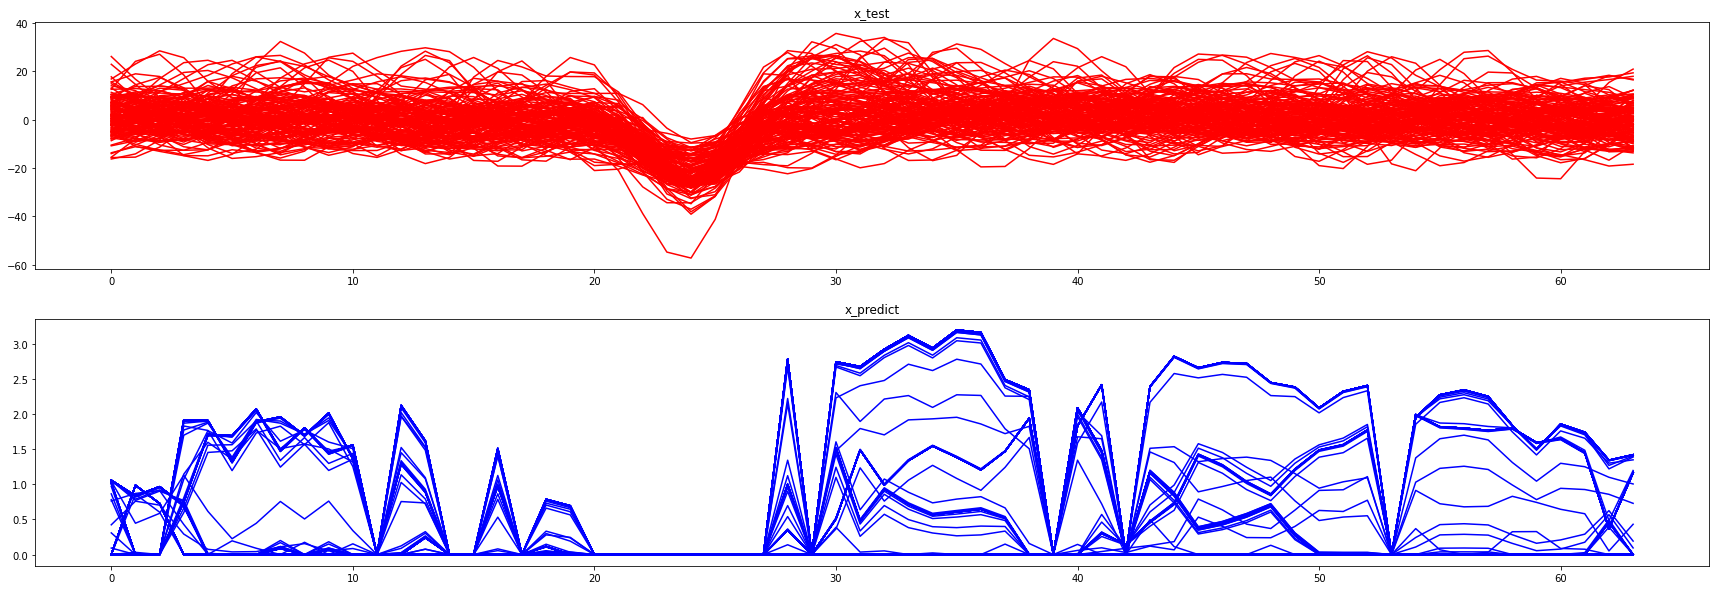

In [27]:
fig = plt.figure(figsize=(30,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.set_title('x_test')
ax2.set_title('x_predict')

x = np.arange(0, 64)
ax1.plot(np.transpose(x_test)[:,0:150], c='r')
ax2.plot(np.transpose(x_predict)[:,0:150], c='b')

plt.show()

In [28]:
# reduce dimension
layer_name = 'encoded'
encoded_layer_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(layer_name).output)
encoded_data = encoded_layer_model(data_concat_raw)
# take a glance
encoded_data = np.transpose(encoded_data)
print(encoded_data.shape)

(2, 4750)


In [22]:
print(encoded_data)

[[ 0.        26.277317  34.703568  ... 53.072372  42.958515  57.70851  ]
 [ 0.         0.8708978  4.4300256 ... 10.407554   0.         7.879488 ]]


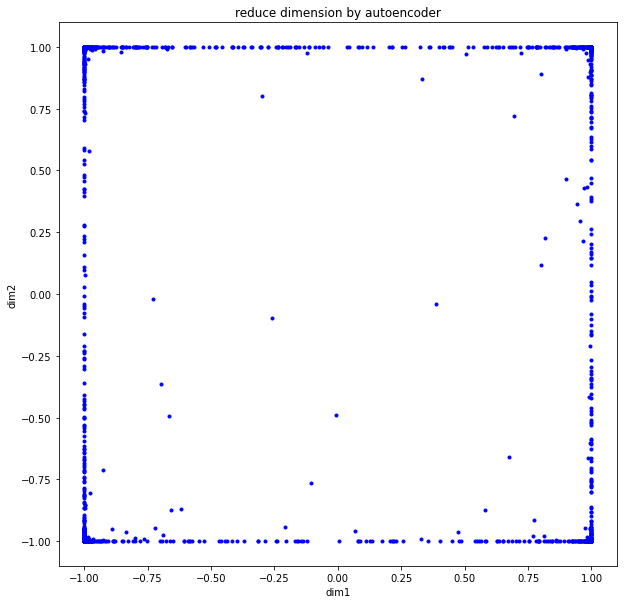

In [29]:
fig = plt.figure(figsize=(10,10))
plt.title('reduce dimension by autoencoder')
plt.xlabel('dim1')
plt.ylabel('dim2')

x = encoded_data[0,:]
y = encoded_data[1,:]
plt.scatter(x, y, c = 'b', marker = '.')

plt.show()

In [ ]:
%run '/content/drive/MyDrive/Colab Notebooks/spike_sorting/k-means.ipynb'

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


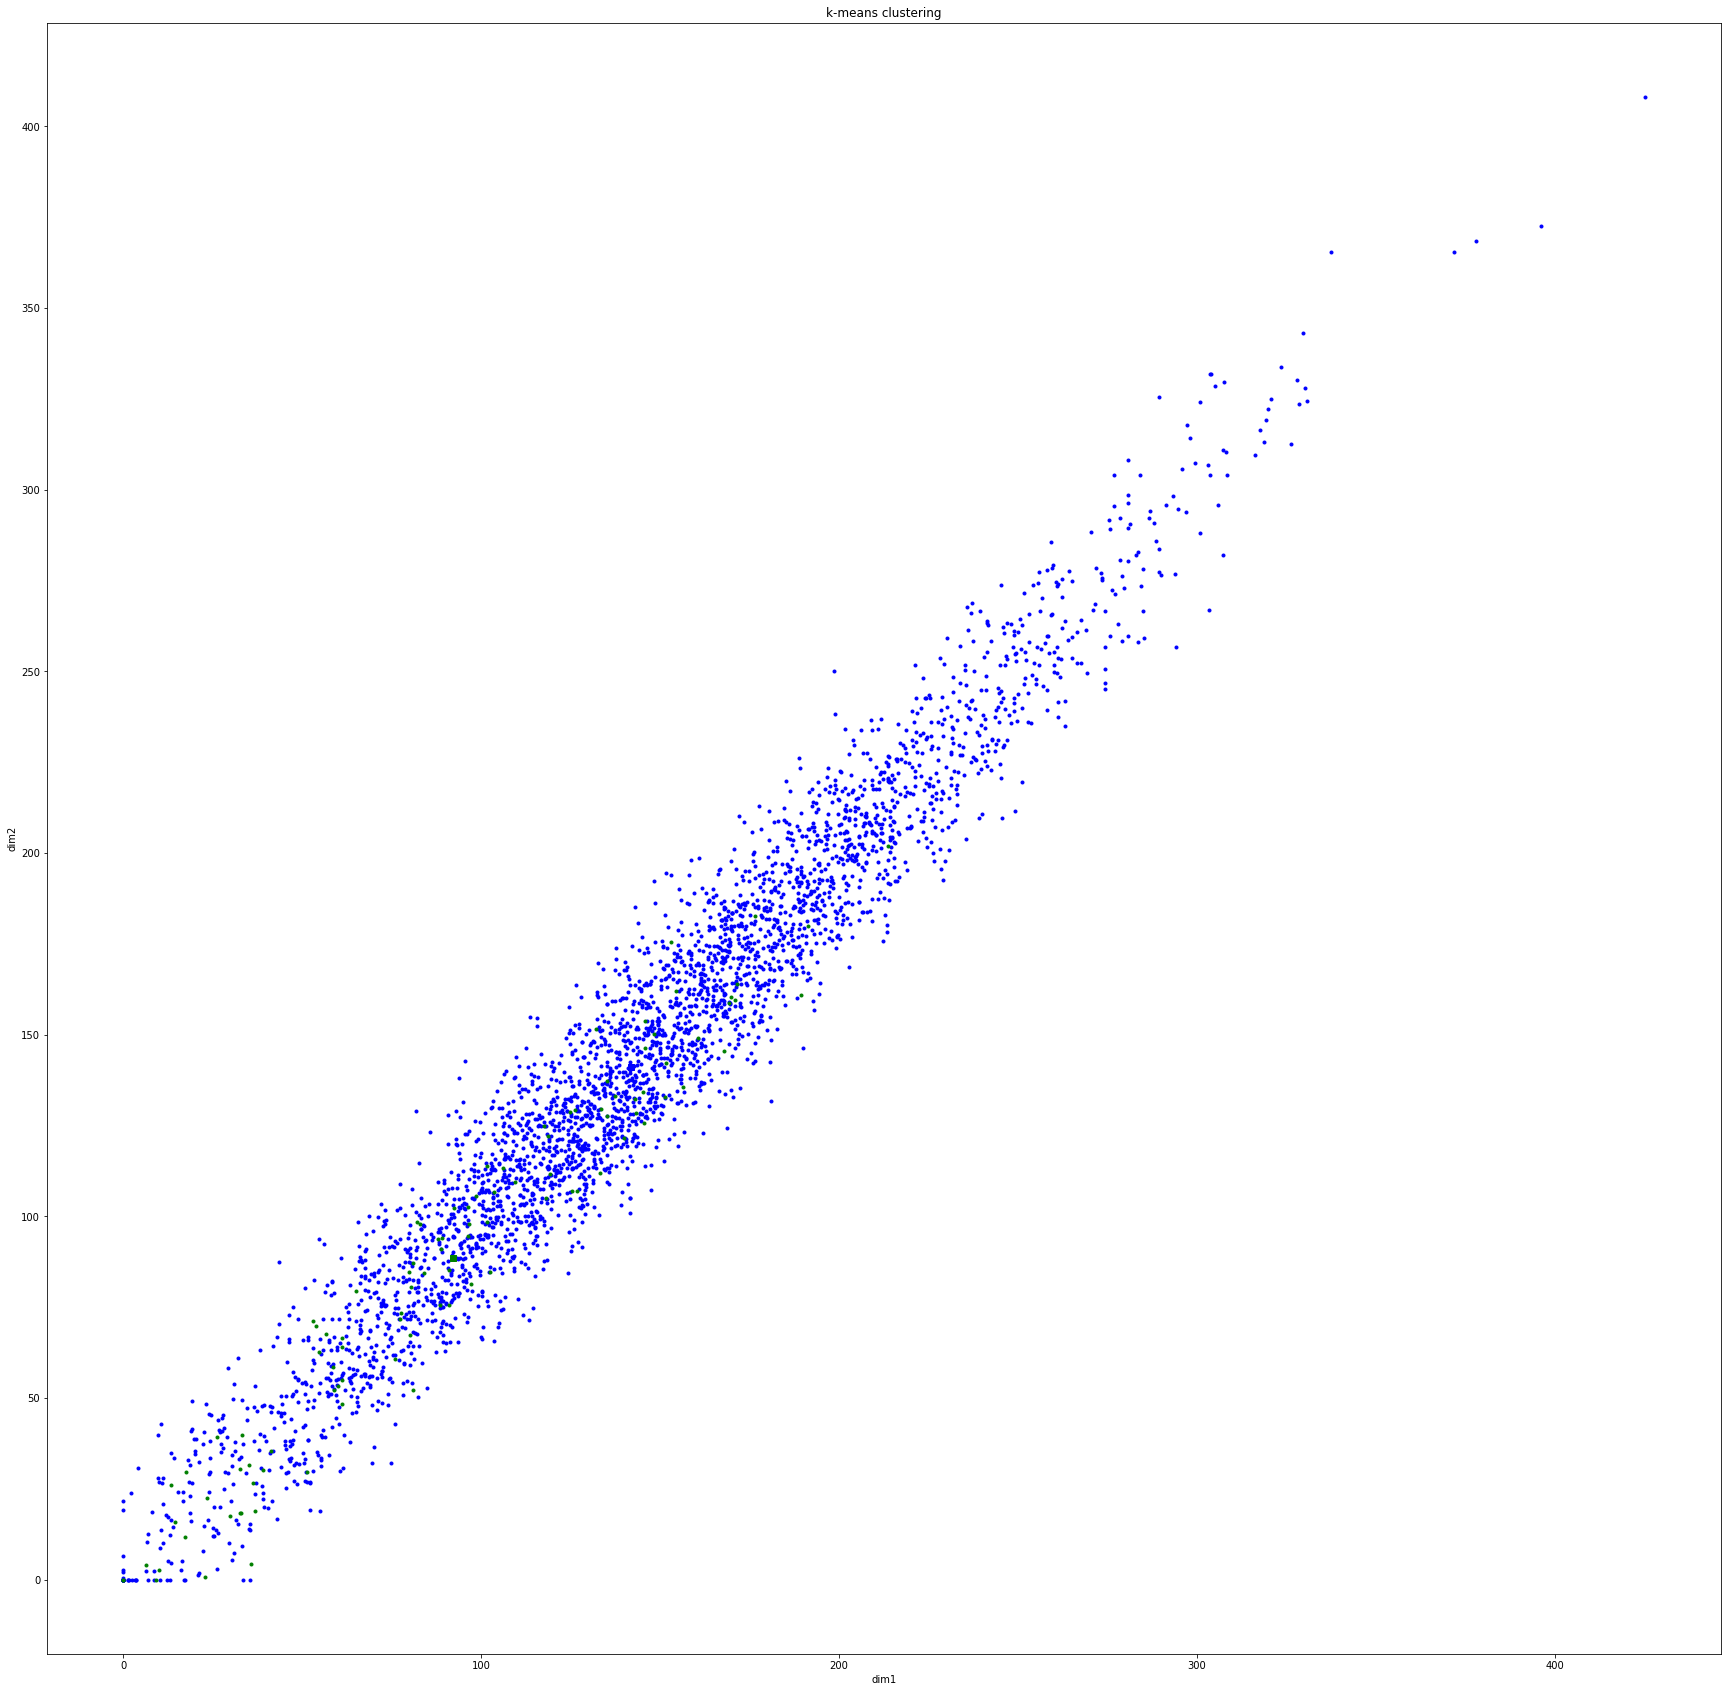

In [ ]:
cluster_assignment, centroids = k_means(np.transpose(encoded_data))
plot_clusters(np.transpose(encoded_data), cluster_assignment, centroids)